In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [2]:
import sys
import resource
def memory_limit():
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (104857600, hard))

memory_limit()

# `bem` 2D Surface Trap example
SimpleTrap

In [3]:
import sys
import logging, os
from time import time
import numpy as np
import resource
import matplotlib as mpl
# Importing pyface.qt is xfor setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# which is incompatible with "pyside" in package "mayavi". Python 2.
# import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool

sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/electrode')

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

### Import STL geometry file

In [4]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    # This notebook is the same as SeidelinTrap.ipynb except for the redrawed stl file.
#     prefix = "htrap" 
#the htrap file that I use to generate these files- I think it has its own mesh? Check this
    prefix = "htrapF"
#     prefix = "htrapS1314_S6gnd"s
#     prefix = "htrapShort"
#     prefix = "htrap_el3_2x300"
#     prefix = "htrap_el4_4slit_2x300"
suffix = ""
print("done")

done


At first coding number of electrode colors are unknown, users need to specify an arbitrary rename argument as a first attempt, then `stl.stl_to_mesh()` will drop unnamed coding numbers below for next formal rename.

In [5]:
# scale to natural units (ion height)
# this seems not right to me- I feel like the ion-to-electrode distance is own for a spherical
# electrode geometry
scale = 72e-6    # Distance from ion to electrode is 40 um.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mpl.rcParams['lines.linewidth'] = 0.2
    mesh.triangulate(opts="a0.01q25.")
else:
    # load electrode faces from colored stl
    # s_nta is intermediate processed stl file.
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mpl.rcParams['lines.linewidth'] = 0.2
    print("Import stl:",os.path.abspath("./"+prefix+".stl"),"\n")
    print("Electrode colors (numbers):\n")
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-3,rename={0:"DC21"})) 

Import stl: /Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples/SimpleTrap/htrapF.stl 

Electrode colors (numbers):

dropping 12319
dropping 31754
dropping 1055
dropping 3171
dropping 8223
dropping 10271
dropping 6175
dropping 13343
dropping 31
dropping 7199
dropping 30653
dropping 17439
dropping 2079
dropping 1023
dropping 14367
dropping 568
dropping 18463
dropping 24607
dropping 23583
dropping 21535
dropping 8776
dropping 15391
dropping 20511
dropping 4127


The formal rename of electrode. Assign each electrode a string name instead of its color coding. Use the numbers you get above.  
`stl.stl_to_mesh()` prints normal vectors (different faces) in each electrode.

In [6]:
# 1023:"DC0",17439:"RF",20083:"DC1",20511:"DC2",8776:"DC3",21535:"DC4",23583:"DC5",
# 24607:"DC6",15391:"DC7",18463:"DC8",568:"DC9",14367:"DC10",
# 1055:"DC11",3171:"DC12",8223:"DC13",10271:"DC14",6175:"DC15",
#  13343:"DC16",31:"DC17",7199:"DC18",2079:"DC19",4127:"DC20",
# 31754:"DC21"      

In [7]:
print(len(s_nta), type(s_nta),"\n")
# s_nta is a length 3 tuple. (normal, triangle, attribute) 
# Normal direction of each triangle, three vetice of triangles, coding number of colors.
print("Triangles:",len(s_nta[0]),"\nColors:",len(s_nta[2]),"\n")    # This isn't right.

# stl_to_mesh() only assigns names and does scaling, doing no triangulation to stl mesh.
# "scale=scale/1e-6" only scales dimensionless scale/1e-6.    1e-6: if stl uses micron as unit. 
#                                       ,6175:"DC10",13343:"DC11",31:"DC12",7199:"DC13",2079:"DC14",4127:"DC15"
#                                       ,21535:"DC16",23583:"DC17",24607:"DC18",18463:"DC19",14367:"DC20"
# mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
#     rename={4127:"DC1",2079:"DC2"}, quiet=False))   
#     # 0:Black, 28165:Cyran, 1882:Yello, 1633:Dark Green, 1530:Orange, 8456:Dark Gray, 24:Red, 24311:Default
#13-14,6-gnd
# 1023:"DC0",31754:"DC1",17439:"RF",20511:"DC2",8776:"DC3",21535:"DC4",23583:"DC5",15391:"DC7",18463:"DC8",568:"DC9",14367:"DC10",
# 1055:"DC11",3171:"DC12",3200:"DC13",6175:"DC15",
#  13343:"DC16",31:"DC17",7199:"DC18",2079:"DC19",4127:"DC20",
# 30653:"DC21"
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-3,
    rename={1023:"DC0",31754:"DC1",17439:"RF",20511:"DC2",8776:"DC3",21535:"DC4",23583:"DC5",24607:"DC6",15391:"DC7",18463:"DC8",568:"DC9",14367:"DC10",
1055:"DC11",3171:"DC12",8223:"DC13",10271:"DC14",6175:"DC15",
 13343:"DC16",31:"DC17",7199:"DC18",2079:"DC19",4127:"DC20",
30653:"DC21"}, quiet=False))


3 <class 'tuple'> 

Triangles: 1968 
Colors: 1968 

dropping 12319
1 planes in electrode DC1
normals vectors:
 [[-2.60208521e-16  0.00000000e+00  1.00000000e+00]]
1 planes in electrode DC11
normals vectors:
 [[4.15363807e-19 8.95639721e-16 1.00000000e+00]]
1 planes in electrode DC12
normals vectors:
 [[4.15363807e-19 5.11564066e-16 1.00000000e+00]]
1 planes in electrode DC13
normals vectors:
 [[4.15363807e-19 2.55442214e-16 1.00000000e+00]]
1 planes in electrode DC14
normals vectors:
 [[ 4.15363807e-19 -3.26298366e-17  1.00000000e+00]]
1 planes in electrode DC15
normals vectors:
 [[ 4.15363807e-19 -3.84755320e-16  1.00000000e+00]]
1 planes in electrode DC16
normals vectors:
 [[ 4.15363807e-19 -6.72827387e-16  1.00000000e+00]]
1 planes in electrode DC17
normals vectors:
 [[ 4.15363807e-19 -8.64895813e-16  1.00000000e+00]]
1 planes in electrode DC18
normals vectors:
 [[ 4.15363807e-19 -1.05696424e-15  1.00000000e+00]]
1 planes in electrode DC21
normals vectors:
 [[8.00688916e-16 0.000000

### Generate triangle mesh with constraints

The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library.

mesh_3_1SOld.txt
Output vtk: /Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples/SimpleTrap/htrapF.vtk


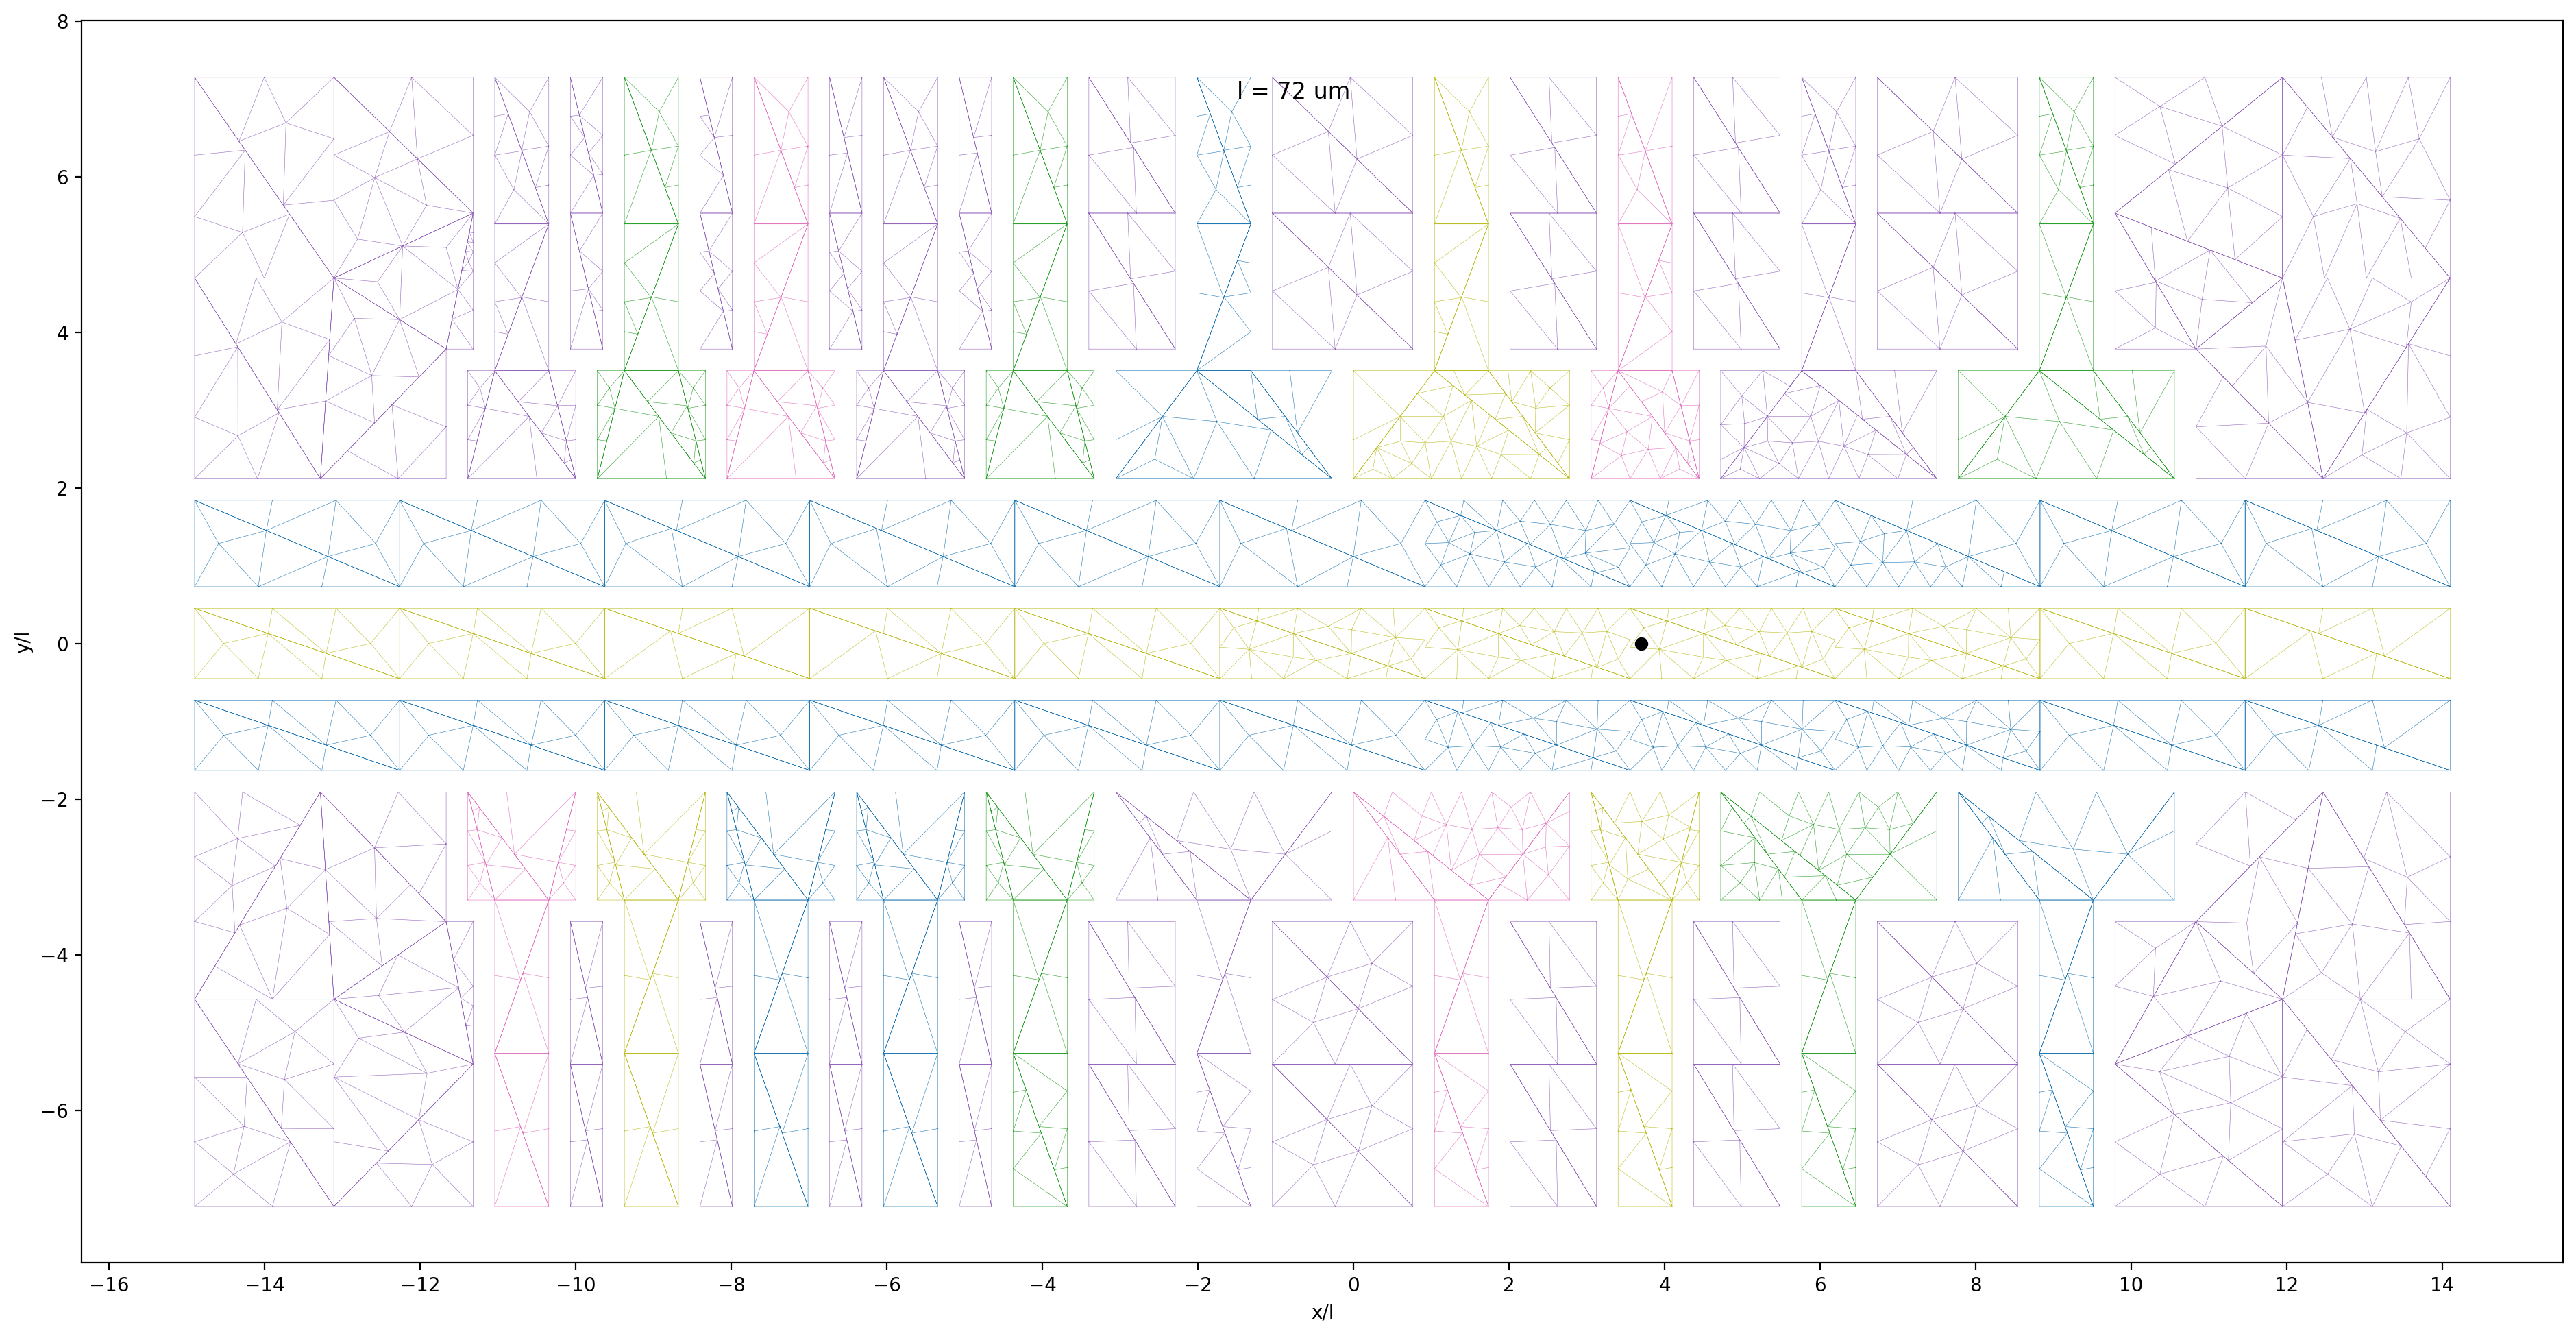

In [8]:
xl = 3.7
yl = 0.0
zl = 1.0
# set .1 max area within 3
# areas_from_constraints specifies sphere with finer mesh inside it.
mpl.rcParams['lines.linewidth'] = 0.2
rad = 3
size = 1
file_name = "mesh_"+str(rad)+"_"+str(size)+"SOld.txt"
print(file_name)
mesh.areas_from_constraints(Sphere(center=np.array([xl,yl,zl]),
           radius=rad, inside=size/10, outside=0.4))  # "inside", "outside" set different mesh densities.
# # retriangulate quality and quiet with areas
mesh.triangulate(opts="q25Q",new = False)
# mesh.areas_from_constraints(Sphere(center=np.array([3.7, 0., 1.]),
#            radius=2.0, inside=0.08, outside=10.))  # "inside", "outside" set different mesh densities.
# save base mesh to vtks
# mesh.to_vtk(prefix+suffix)
mesh.to_vtk(prefix+suffix)
print("Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk"))    # output path

# Plot triangle meshes.
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(24,12), dpi=200)
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-1.5,7,"l = %d um"%(scale/1e-6),fontsize=12)
ax.plot(xl,yl,marker = 'o',color = 'k')
# ax.grid(axis = 'both')
yticks = np.arange(-100, 100, 2)
ax.set_yticks(yticks)
xticks = np.arange(-100, 100, 2)
ax.set_xticks(xticks)
mesh.plot(ax)

### Main boundary element calculations

In `run_job` function, `job` is `Configuration` instance and `grid` is discretirized spatial grid (not the mesh). The general workflow (also the routine of BEM method) are:  
1. `solve_singularities()` solves charge distributions by iterative methods to make it consistent with one electrode at 1V and others at 0V (unit potentials). `adapt_mesh()` refines meshes adaptively to achieve certain precision while solving sigulartities.
2. Compute potentials on given grid points by `simulate()`, based on the charge distributions gotten previously.
3. Potential data of each unit potential are saved seperately to a `Result` instance, and also export to VTK files.
4. Return total accumulated charge per electrode in the end.

Major calculations calls `fastlap` C library which uses a pre-conditioned, adaptive, multipole-accelerated algorithm for solving Laplace problem. Two parameters control multipole acceleration.
+ num_mom, the number of multipole
+ num_lev, the number of levels in the hierarchical spatial decomposition.  
num_lev=1 means fdirect computation without multipole acceleration. See fastlap ug.pdf and README.rst.

In [9]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min angle 25 deg.
#     print("clip")
    memory_limit()
#     job.adapt_mesh(triangles=1e2, opts="q25Q")
#     job.adapt_mesh(triangles=1e3, opts="q25Q")
#     print("clop")
    # solve for surface charges
    job.solve_singularities(num_mom=5, num_lev=3)
#     print("done")
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=4)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

Create a grid in unit of scaled length `l`. Only choose the interested region (trap center) to save time.

For reference, to compute Seidelin trap, grid shape = (60, 60, 60) takes 266 s, while shape = (150, 150, 150) takes 3369 s.

In [10]:
# grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
n, s = 100, 0.00002
Lx, Ly, Lz = 0.0004,0.0004,0.0004 # in the unit of scaled length l
sx, sy, sz = s, s, s
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/s).astype('int') for L in (Lx, Ly, Lz)]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(xl,yl,zl), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin())

Size/l: 0.0004 0.0004 0.0004
Step/l: 2e-05 2e-05 2e-05
Shape (grid point numbers): 20 20 20
Grid origin/l: [ 3.69981e+00 -1.90000e-04  9.99810e-01]


Calculation. Parallel computation `Pool().map`

In [11]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() picks one electrode each time.
# run the different electrodes on the parallel pool
pmap = Pool().map # parallel map
# pmap = map # serial map
t0 = time()
list(pmap(run_job, ((job, grid, prefix+suffix) for job in jobs)))
print("Computing time: %f s"%(time()-t0))
# run_job casts a word after finishing each electrode.

finished job DC1
finished job DC14
finished job DC16
finished job DC12
finished job DC11
finished job DC15
finished job DC13
finished job DC17
finished job DC18
finished job DC9finished job DC0

finished job DC21
finished job DC10
finished job DC8
finished job RF
finished job DC6
finished job DC4
finished job DC7
finished job DC19
finished job DC5
finished job DC2
finished job DC3
finished job DC20
Computing time: 11.248799 s


### Contour plot of potential/pseudo-potential in 3 directions

In [14]:
mtinit()
# isocontour plot of RF pseudopotential radially from x (axial) direction
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2.
print("yz plane, RF pseudo")
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.set_aspect("equal")
ax.grid(axis = 'both')
yticks = np.arange(0, 1.7, 0.1)
ax.set_yticks(yticks)
xticks = np.arange(-2, 2, 0.1)
ax.set_xticks(xticks)
ax.set_ylim(0,2)
ax.contourf(x[1], x[2], p, levels=np.linspace(0.6e-4, 1e-2, 300), cmap=plt.cm.RdYlGn)

NameError: name 'mtinit' is not defined

In [ ]:
ax.contourf?

(2, 2)
yz plane, DC21 potential


/Users/Ben/opt/anaconda3/envs/py3bem/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


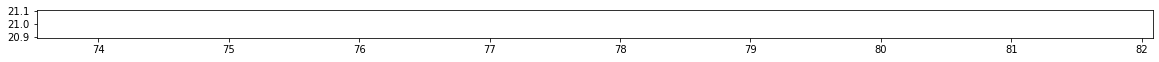

In [132]:
# isocontour plot of DC potential from x (axial) direction
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21".split()
result = Result.from_vtk(prefix+suffix, "DC1")
pseed = result.potential
Vx = np.zeros((pseed.shape[1],pseed.shape[0]))
Vy = np.zeros((pseed.shape[1],pseed.shape[0]))
for em in strs:
    ele = em
    result = Result.from_vtk(prefix+suffix, ele)
    p = result.potential
    maxp = np.amax(p)
#     print("p max", maxp)
    x = grid.to_mgrid()[:,p.shape[0]//2]
#     print(np.shape(Vx))
    p = p[p.shape[0]//2]
    Vx = Vx+x[0]
    Vy = Vy+x[2]
print(np.shape(Vx))
print("yz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
fig.set_size_inches(20,10)

ax.contour(Vx, Vy, p, levels=np.linspace(0, maxp, 20), cmap=plt.cm.Reds)    # 2e-2

In [133]:
# isocontour plot of electrode potential (electrode profile) from z direction
ele = "RF"
result = Result.from_vtk(prefix+suffix, ele)
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]//2-10]
p = p[:,:,p.shape[2]//2-10]
print("xy plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_size_inches(20,10)

ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp*1, 200), cmap=plt.cm.Blues)

p max 0.00039085962789


IndexError: index -9 is out of bounds for axis 3 with size 2

In [ ]:
# isocontour plot of single DC potential from y direction
ele = "DC21"
result1 = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,:,p.shape[1]//2]
p = p[:,p.shape[1]//2]
print("xz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_size_inches(20,10)
ax.contourf(x[0], x[2], p, levels=np.linspace(0, maxp, 30), cmap=plt.cm.Greens)

In [ ]:
result = Result.from_vtk(prefix+suffix, "DC1")
p = result.potential
print(coord.shape)    # length nx, ny, nz
print(coord[:,p.shape[0]//2].shape)    # plane at nx/2
print(p.shape)

### 3D plot of mesh and potential isocontour
By mayavi GUI (seems to have problem now.)

In [ ]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Can't lauch GUI through X11 remote and caused dead kernel.

## Data processing
Using `electrode` package. (`GridElectrode.from_result()` method has problems for now, use `from_vtk()` directly.)  
I perfer to split data processing part to a new notebook. See `DataProcessing_SE.ipynb`.

In [14]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode,utils
import csv
import scipy.constants as ct
s = System()
# load the electrostatics results into a electrode.System()
# "DC0 DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21 RF
# strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21".split()
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21".split()
# excl = {
#     "DC6": ["Null",0],
#     "DC14": [13,12]
#        }
exp = 4
offset = 1

npl = 9-offset
lamb = np.zeros((len(strs),npl))
i = 0

r = Result.from_vtk(prefix, "DC1")
e = GridElectrode.from_result(r,maxderiv = exp)
print("here")
print(np.shape(e.data[1]))
for name in strs:
    if name in excl:
        print(name)
        arlo = np.zeros(npl)
    else:
        r = Result.from_vtk(prefix, name)
        e = GridElectrode.from_result(r,maxderiv = exp)
        e.name = name
        s.append(e)
        arlo = np.array([])
        for p in np.arange(offset,exp):
            if name == 'RF':
                print("trip")
            else:
                sx = 2
                sy = 2
                sz = 2
    #             print(vx)
                pot = np.zeros(2*p+1)
                pt = np.array([xl,yl,zl])
            outvals = utils.cartesian_to_spherical_harmonics(np.transpose(e.data[p][nx//2-1:nx//2+1,
                                                                                    ny//2-1:ny//2+1,nz//2-1:nz//2+1,:]))
            outvals = np.sum(np.sum(np.sum(outvals,1),1),1)
            arlo = np.append(arlo, outvals)
    lamb[i] = arlo[0:npl]
    i = i+1
print(np.shape(lamb))
l = 72e-6 # length scale
u = 100.# peak rf voltage
o = 36.e6*2*np.pi # rf frequency
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
rf_scale = s.rf_scale(m,q,l,o)
r = Result.from_vtk(prefix+suffix, "RF")
p = r.pseudo_potential
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
e = GridElectrode.from_result(r)
e.name = "RF"
s.append(e)
s["RF"].rf = u # peak rf voltage

      
#     print(outvals[0][2])
#     print(utils.cartesian_to_spherical_harmonics(e.data[0:1][5][5][5]))
#     e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)
# print(np.dot(np.transpose(lamb),np.transpose(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))))
# print(arlo)

    

here
(20, 20, 20, 3)


NameError: name 'excl' is not defined

In [15]:
# u2old = np.array([-0.0178185, 0.0153893, 0.0434955, 0.473985, 3.0024, -3.33158, \
# -4.52325, -0.919275, -0.716663, -0.784725, -0.0289778, 0.0169508, \
# 0.0820125, 0.601035, 2.83178, -3.5178, -6.54885, -0.756, 0.840975, \
# -0.0394898, -0.90165])/7
u2old = np.array([-0.054593, 0.057666, -0.66996, 0.05951, -0.057175, -0.058409, \
-0.047644, -0.038418, -0.031, -0.02519, -0.045262, -0.077023, \
-0.68039, -0.074042, -0.034745, -0.039145, -0.03209, -0.025515, \
-0.019994, -0.01579, -0.086705])
lambT = np.transpose(lamb)
# commando = np.linalg.inv(lambT)
commandoT = np.zeros((8,len(strs)))
u2vec = np.zeros(8)
u2vec[6-offset] = 1
for i in np.arange(0,8):
        B = np.zeros(npl)
        B[i] = 1
        A = np.linalg.lstsq(lambT,B,rcond=None)
        commandoT[i] = A[0]*(np.dot(lambT,u2old)[5])
lambT = lambT[0:8]
commando = np.transpose(commandoT)
from tabulate import tabulate
print("checking construction")
print(np.dot(lambT,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))
print(arlo)


print("checking inverse")
print(tabulate(np.around(np.dot(commando,lambT))))

print("u2 from pinv")
u2fromInv = np.around(np.dot(commando,u2vec),1)
# print(u2fromInv)
for stri in excl:
    print(stri)
    idx = excl[stri][0]
    new = excl[stri][1]
    if idx != "Null":
        commandoT[:,idx] = commandoT[:,new]
l1 = commandoT.flatten()
lmid = l1
lmid[63:84] = l1[147:168]
lmid[84:105] = l1[105:126]
lmid[105:126] = l1[63:84]
lmid[126:147] = l1[84:105]
lmid[147:168] = l1[126:147]
# lmid = lamb.flatten()
print("u2 from indexing")
u2 = np.around(commando[:,5],5)
# el3 solution
u2 = np.array([-0.054593, 0.057666, -0.66996, 0.05951, -0.057175, -0.058409, \
-0.047644, -0.038418, -0.031, -0.02519, -0.045262, -0.077023, \
-0.68039, -0.074042, -0.034745, -0.039145, -0.03209, -0.025515, \
-0.019994, -0.01579, -0.086705])
#el7 solution
print("getting u2 again")
print(np.around(np.dot(lambT,u2)/(np.dot(lambT,u2old)[5]),3))
print(np.linalg.norm((np.dot(lambT,u2)-[0,0,0,0,0,np.dot(lambT,u2)[5],0,0])/np.dot(lambT,u2)[5]))

print("norm")
print(np.linalg.norm(u2))


import pandas as pd

pd.DataFrame(lmid).to_csv(file_name, header=None, index=None, float_format='%.15f')

checking construction
[0. 0. 0. 0. 0. 0. 0. 0.]
[]
checking inverse
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0 

NameError: name 'excl' is not defined

In [13]:
# isocontour plot of DC potential from x (axial) direction
from electrode import System, GridElectrode
# strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21".split()
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21".split()
Vx = np.zeros(())
# Vx = np.zeros((26,38))
i = 0
for inp in strs:
    arlo = np.array([])
    if inp in excl:
        print(inp)
    else:
        r = Result.from_vtk(prefix+suffix, inp)
        if inp == "RF":
            r = Result.from_vtk(prefix+suffix, "RF")
            p = r.pseudo_potential
        else:
            p = r.potential
        maxp = np.amax(p)
    #     x = grid.to_mgrid()[:,p.shape[0]//2]
    #     p = p[p.shape[0]//2]
        x = grid.to_mgrid()[:,:,p.shape[1]//2]
        p = p[:,p.shape[1]//2]
        if inp == "RF":
            print("trip")
            Vx = Vx+p*0
        else:
    #         s[inp].dc = u2[i]*1
            Vx = Vx+(p*u2[i]*1)
    #     else:
    #         Vx = Vx
    print(i)
    i = i+1

# print("yz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal") 
# yz plane should use x[1], x[2]. wwc
fig.set_size_inches(20,10)
# ax.set_ylim(-1,2)
ax.grid(axis = 'both')
yticks = np.arange(-10,10,1)
ax.set_yticks(yticks)
xticks = np.arange(-10,10,1)
ax.set_xticks(xticks)
# ax.plot(3.7,1.8,marker = 'o')
ax.plot(xl,zl,marker = 'o',color='k')
ax.set_ylim(zl-Lz/2,zl+Lz/2)
ax.set_xlim(xl-Lx/2,xl+Lx/2)
print(Vx.min())
print(Vx.max())
print(np.shape(Vx))
yticks = np.arange(zl-Lz/2, zl+Lz/2, 0.02)
ax.set_yticks(yticks)
xticks = np.arange(xl-Lx/2,xl+Lx/2, 0.02)
ax.set_xticks(xticks)
# ax.contourf(x[1], x[2], Vx, levels=np.linspace(-10,10,20), cmap=plt.cm.RdYlGn)
# 2e-2
ax.contourf(x[0], x[2], Vx, levels=np.linspace(Vx.min(),Vx.max(),100), cmap=plt.cm.RdYlGn) # 2e-2


NameError: name 'excl' is not defined

trigger
trigger
trip
-0.06385381404541521
-0.06385260840267223
(20, 20)


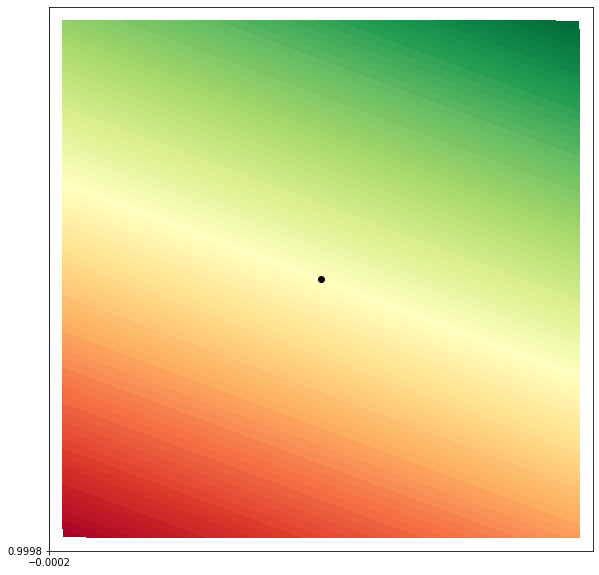

In [198]:
# isocontour plot of DC potential from x (axial) direction
from electrode import System, GridElectrode
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21 RF".split()
pseed = r.potential
Vx = np.zeros(())
i = 0
for inp in strs:
    if inp in excl:
        print("trigger")
    else:
        arlo = np.array([])
        r = Result.from_vtk(prefix+suffix, inp)
        if inp == "RF":
            p = r.pseudo_potential
    # method = 'Newton-CG'
        else:
            p = r.potential
        maxp = np.amax(p)
        x = grid.to_mgrid()[:,p.shape[0]//2]
        p = p[p.shape[0]//2]
        if inp == "RF":
            print("trip")
            Vx = Vx+p*0
        else:
            val = p*u2[i]*1
    #         s[inp].dc = u2[i]
            Vx = Vx+val
    #     else:
    #         Vx = Vx
    i = i+1

# print("yz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
fig.set_size_inches(20,10)
# ax.set_ylim(-1,2)
ax.grid(axis = 'both')
# ax.plot(3.7,1.8,marker = 'o')
ax.plot(yl,zl,marker = 'o',color='k')
ax.set_xlim(yl-Ly/2,yl+Ly/2)
ax.set_ylim(zl-Lz/2,zl+Lz/2)
xticks = np.arange(yl-Ly/2,yl+Ly/2,0.02)
ax.set_xticks(xticks)
yticks = np.arange(zl-Lz/2,zl+Lz/2,0.02)
ax.set_yticks(yticks)
print(Vx.min())
print(Vx.max())
print(np.shape(Vx))
# ax.contourf(x[1], x[2], Vx, levels=np.linspace(-10,10,20), cmap=plt.cm.RdYlGn)    # 2e-2
v = np.linspace(Vx.min(),Vx.max(), 80)
ax.contourf(x[1], x[2], Vx, levels=v, cmap=plt.cm.RdYlGn)    # 2e-2

In [162]:
import scipy.constants as ct
l = 72e-6 # length scale
u = 100.# peak rf voltage
o = 36e6*2*np.pi # rf frequency
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.

rf_scale = s.rf_scale(m,q,l,o)
s["RF"].rf = u # peak rf voltage
# method = 'Newton-CG'

In [412]:
# x0 = s.minimum((4.34507963, -0.04303287,  0.99403176))
x0 = np.array([ 3.89080547, -0.05081175,  1.05714154])
print(s.electrical_potential(x0)[0])
for _ in s.analyze_static(x0,m=m,l=l, o=o):
    print(_)

AttributeError: 'float' object has no attribute 'electrical_potential'

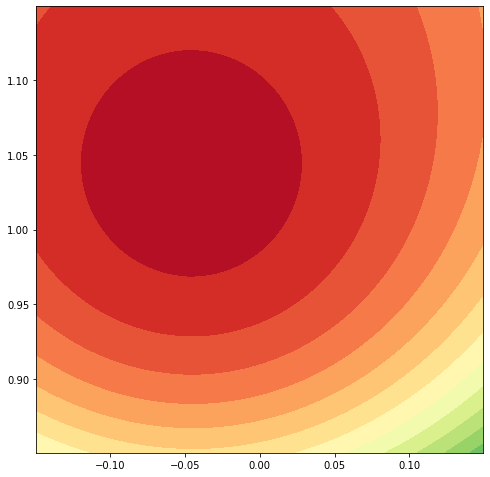

In [14]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(-3, 100, 17)
fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_size_inches(8,10)
ax.contourf(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.RdYlGn)